In [3]:
import os

import numpy as np
from PIL import Image

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import grad
from torchvision import transforms
from torchvision import datasets
import torchvision.datasets.utils as dataset_utils

# Colored Mnist data set

In [15]:
def color_grayscale_arr(arr, red=True):
    """Converts grayscale image to either red or green"""
    assert arr.ndim == 2
    dtype = arr.dtype
    h, w = arr.shape
    arr = np.reshape(arr, [h, w, 1])
    if red:
        arr = np.concatenate([arr,
                          np.zeros((h, w, 2), dtype=dtype)], axis=2)
    else:
        arr = np.concatenate([np.zeros((h, w, 1), dtype=dtype),
                          arr,
                          np.zeros((h, w, 1), dtype=dtype)], axis=2)
    return arr


class ColoredMNIST(datasets.VisionDataset):
    """
    Colored MNIST dataset for testing IRM. Prepared using procedure from https://arxiv.org/pdf/1907.02893.pdf
    Args:
    root (string): Root directory of dataset where ``ColoredMNIST/*.pt`` will exist.
    env (string): Which environment to load. Must be 1 of 'train1', 'train2', 'test', or 'all_train'.
    transform (callable, optional): A function/transform that  takes in an PIL image
      and returns a transformed version. E.g, ``transforms.RandomCrop``
    target_transform (callable, optional): A function/transform that takes in the
      target and transforms it.
    """
    def __init__(self, root='./data', env='train1', transform=None, target_transform=None):
        super(ColoredMNIST, self).__init__(root, transform=transform,
                                target_transform=target_transform)

        self.prepare_colored_mnist()
        if env in ['train1', 'train2', 'test']:
            self.data_label_tuples = torch.load(os.path.join(self.root, 'ColoredMNIST', env) + '.pt')
        elif env == 'all_train':
            self.data_label_tuples = torch.load(os.path.join(self.root, 'ColoredMNIST', 'train1.pt')) + \
                               torch.load(os.path.join(self.root, 'ColoredMNIST', 'train2.pt'))
        else:
            raise RuntimeError(f'{env} env unknown. Valid envs are train1, train2, test, and all_train')

    def __getitem__(self, index):
        """
        Args:
        index (int): Index

        Returns:
        tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data_label_tuples[index]

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self):
        return len(self.data_label_tuples)

    def prepare_colored_mnist(self):
        colored_mnist_dir = os.path.join(self.root, 'ColoredMNIST')
        if os.path.exists(os.path.join(colored_mnist_dir, 'train1.pt')) \
          and os.path.exists(os.path.join(colored_mnist_dir, 'train2.pt')) \
          and os.path.exists(os.path.join(colored_mnist_dir, 'test.pt')):
            print('Colored MNIST dataset already exists')
            return

        print('Preparing Colored MNIST')
        train_mnist = datasets.mnist.MNIST(self.root, train=True, download=True)

        train1_set = []
        train2_set = []
        test_set = []
        for idx, (im, label) in enumerate(train_mnist):
            if idx % 10000 == 0:
                print(f'Converting image {idx}/{len(train_mnist)}')
            im_array = np.array(im)

        # Assign a binary label y to the image based on the digit
            binary_label = 0 if label < 5 else 1

      # Flip label with 25% probability
            if np.random.uniform() < 0.25:
                binary_label = binary_label ^ 1

      # Color the image either red or green according to its possibly flipped label
            color_red = binary_label == 0

      # Flip the color with a probability e that depends on the environment
            if idx < 20000:
            # 20% in the first training environment
                if np.random.uniform() < 0.2:
                    color_red = not color_red
            elif idx < 40000:
                # 10% in the first training environment
                if np.random.uniform() < 0.1:
                    color_red = not color_red
            else:
                # 90% in the test environment
                if np.random.uniform() < 0.9:
                    color_red = not color_red

            colored_arr = color_grayscale_arr(im_array, red=color_red)

            if idx < 20000:
                train1_set.append((Image.fromarray(colored_arr), binary_label))
            elif idx < 40000:
                train2_set.append((Image.fromarray(colored_arr), binary_label))
            else:
                test_set.append((Image.fromarray(colored_arr), binary_label))

      # Debug
      # print('original label', type(label), label)
      # print('binary label', binary_label)
      # print('assigned color', 'red' if color_red else 'green')
      # plt.imshow(colored_arr)
      # plt.show()
      # break
    
        def makedir_exist_ok(dirpath):
            try:
                os.makedirs(dirpath)
            except OSError as e:
                if e.errno == errno.EEXIST:
                    pass
                else:
                    raise

        makedir_exist_ok(colored_mnist_dir)
        torch.save(train1_set, os.path.join(colored_mnist_dir, 'train1.pt'))
        torch.save(train2_set, os.path.join(colored_mnist_dir, 'train2.pt'))
        torch.save(test_set, os.path.join(colored_mnist_dir, 'test.pt'))

In [29]:
train1_set = ColoredMNIST(root='./data', env='train1')

Colored MNIST dataset already exists


In [34]:
train2_set = ColoredMNIST(root='./data', env='train2')

Colored MNIST dataset already exists


In [32]:
trainall_set = ColoredMNIST(root='./data', env='all_train')

Colored MNIST dataset already exists


In [33]:
test_set = ColoredMNIST(root='./data', env='test')

Colored MNIST dataset already exists


# ERM

In [5]:
import numpy as np
import pickle

In [6]:
with open("erm_all.pkl", "rb") as f:
    out = pickle.load(f)

In [19]:
def mask(result_indices):
    mask = []
    for trial in range(len(result_indices)):
        trainset_mask = np.zeros(40000, dtype=bool)
        trainset_mask[result_indices[trial]] = True
        mask.append(trainset_mask)
    return np.vstack(mask)

In [20]:
trainset_mask = mask(out['indices'])
inv_mask = np.logical_not(trainset_mask)
trainset_correctness = out['acc_train']
testset_correctness = out['acc_test']
  
def _masked_avg(x, mask, axis=0, esp=1e-10):
    return (np.sum(x * mask, axis=axis) / np.maximum(np.sum(mask, axis=axis), esp)).astype(np.float32)

def _masked_dot(x, mask, esp=1e-10):
    x = x.T.astype(np.float32)
    return (np.matmul(x, mask) / np.maximum(np.sum(mask, axis=0, keepdims=True), esp)).astype(np.float32)

mem_est = _masked_avg(trainset_correctness, trainset_mask) - _masked_avg(trainset_correctness, inv_mask)
infl_est = _masked_dot(testset_correctness, trainset_mask) - _masked_dot(testset_correctness, inv_mask)

In [8]:
import matplotlib.pyplot as plt

### Memory and influence histogram

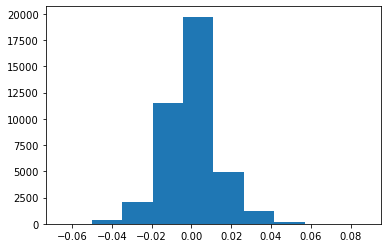

In [21]:
plt.hist(mem_est)
plt.savefig('mem_est.png', dpi=300, bbox_inches='tight')
plt.show()

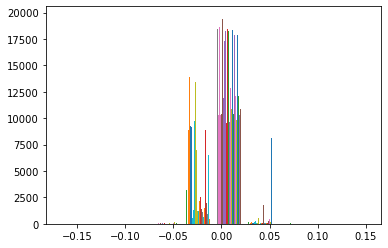

In [25]:
plt.hist(infl_est)
plt.savefig('infl_est.png', dpi=300, bbox_inches='tight')
plt.show()

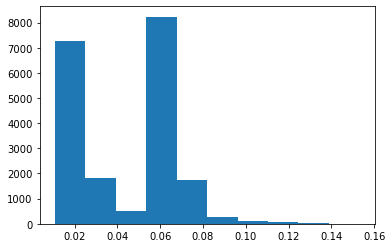

In [154]:
plt.hist(testset_maxinfl)
plt.savefig('max_infl_est.png', dpi=300, bbox_inches='tight')
plt.show()

### High influence pair

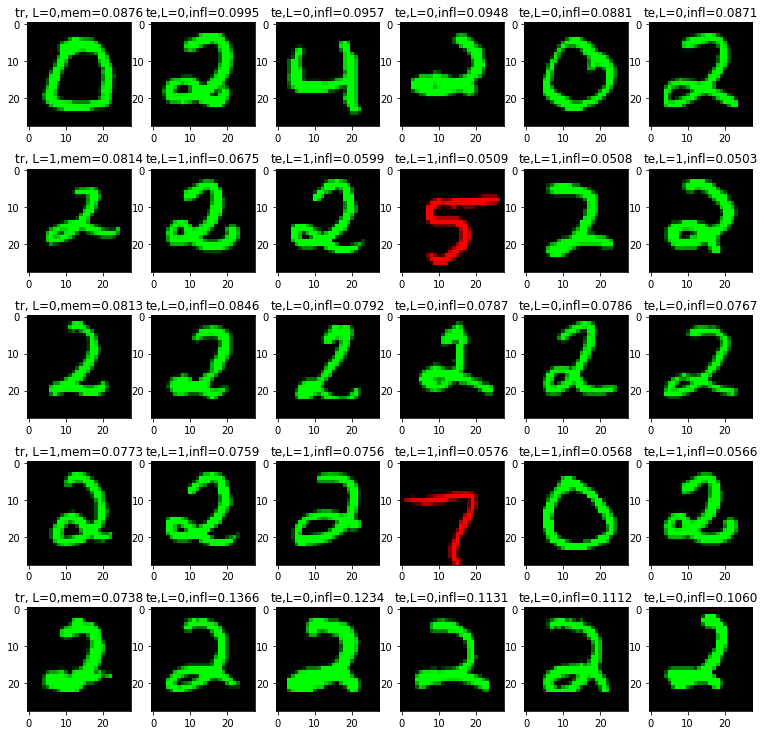

In [155]:
mem_est = list(mem_est)
high_mem_ind_top_5 = np.argsort(mem_est)[::-1][:5]
fig = plt.figure(figsize=(13, 13))
ax = []
for ind_mem in range(5):
    high_mem_ind = high_mem_ind_top_5[ind_mem]
    infl_mem_high = list(infl_est[:,high_mem_ind])
    high_mem_influ_top5ind = np.argsort(infl_mem_high)[::-1][:5]
    img, label = trainall_set[high_mem_ind]
    mem = mem_est[high_mem_ind]
    ax.append(fig.add_subplot(5, 6, 1 + ind_mem*6))
    ax[-1].set_title(f'tr, L={label},mem={mem:.4f}')
    plt.imshow(img)
    for i in range(5):
        img, label = test_set[high_mem_influ_top5ind[i]]
        infl = infl_mem_high[high_mem_influ_top5ind[i]]
        ax.append(fig.add_subplot(5, 6, 2 + i + ind_mem*6))
        ax[-1].set_title(f'te,L={label},infl={infl:.4f}') 
        plt.imshow(img)
plt.savefig('high_infl_pair.png', dpi=300, bbox_inches='tight') 
plt.show()

most influence test sample and corresponding training samples

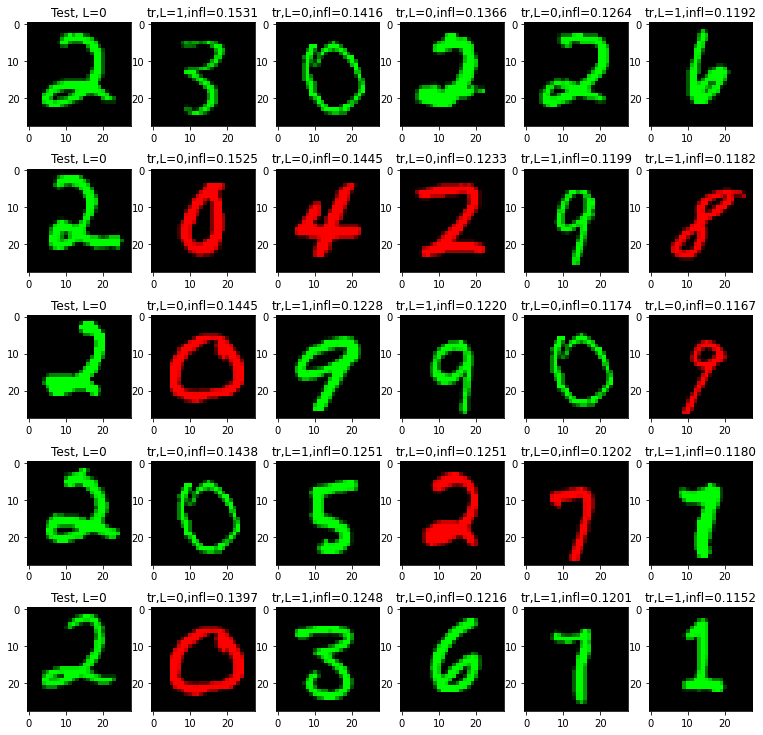

In [142]:
fig = plt.figure(figsize=(13, 13))
ax = []
idx_sorted = np.argsort(np.max(infl_est, axis=1))[::-1]
for i in range(5):
    idx_tt = idx_sorted[i]
    img, label = test_set[idx_tt]
    ax.append(fig.add_subplot(5, 6, 1 + i*6))
    ax[-1].set_title(f'Test, L={label}') 
    plt.imshow(img)
    tr_ind = np.argsort(infl_est[idx_tt])[::-1]
    for ind in range(5):
        img, label = trainall_set[tr_ind[ind]]
        infl = infl_est[idx_tt, tr_ind[ind]]
        ax.append(fig.add_subplot(5, 6, 2 + ind + i*6))
        ax[-1].set_title(f'tr,L={label},infl={infl:.4f}') 
        plt.imshow(img)    
plt.show()  

# IRM

In [47]:
with open("irm_all.pkl", "rb") as f:
    out_irm = pickle.load(f)

In [49]:
trainset_mask_irm = mask(out_irm['indices'])
inv_mask_irm = np.logical_not(trainset_mask_irm)
trainset_correctness_irm = out_irm['acc_train']
testset_correctness_irm = out_irm['acc_test']
  
mem_est_irm = _masked_avg(trainset_correctness_irm, trainset_mask_irm) - _masked_avg(trainset_correctness_irm, inv_mask_irm)
infl_est_irm = _masked_dot(testset_correctness_irm, trainset_mask_irm) - _masked_dot(testset_correctness_irm, inv_mask_irm)

In [112]:
trainset_correctness_irm.mean()

0.7152107536764706

In [113]:
testset_correctness_irm.mean()

0.5601724264705882

### Memory and influence histogram


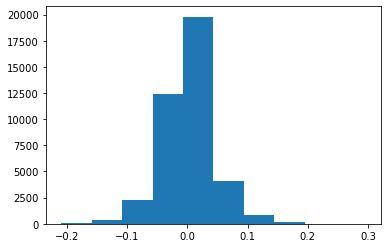

In [16]:
plt.hist(mem_est_irm)
plt.savefig('mem_est_irm.png', dpi=300, bbox_inches='tight')
plt.show()

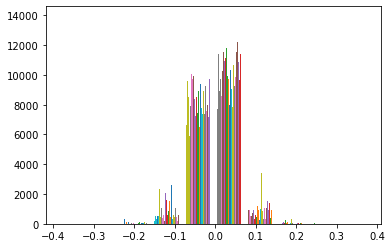

In [17]:
plt.hist(infl_est_irm)
plt.savefig('infl_est_irm.png', dpi=300, bbox_inches='tight')
plt.show()

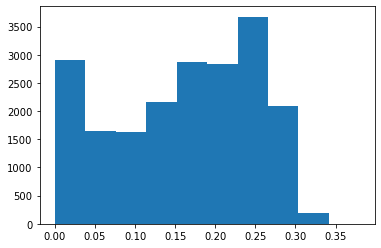

In [168]:
plt.hist(testset_maxinfl_irm)
plt.savefig('max_infl_est_irm.png', dpi=300, bbox_inches='tight')
plt.show()

### high influence pair

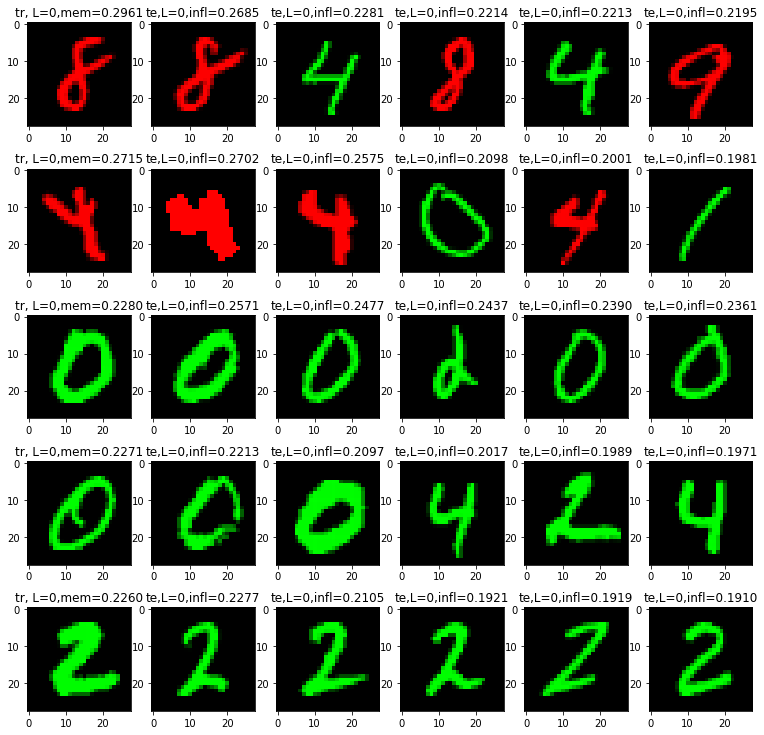

In [165]:
mem_est_irm = list(mem_est_irm)
high_mem_ind_irm_top_5 = np.argsort(mem_est_irm)[::-1][:5]
fig = plt.figure(figsize=(13, 13))
ax = []
for ind_mem in range(5):
    high_mem_ind_irm = high_mem_ind_irm_top_5[ind_mem]
    infl_mem_high_irm = list(infl_est_irm[:,high_mem_ind_irm])
    high_mem_influ_top5ind_irm = np.argsort(infl_mem_high_irm)[::-1][:5]
    img, label = trainall_set[high_mem_ind_irm]
    mem = mem_est_irm[high_mem_ind_irm]
    ax.append(fig.add_subplot(5, 6, 1 + ind_mem*6))
    ax[-1].set_title(f'tr, L={label},mem={mem:.4f}')
    plt.imshow(img)
    for i in range(5):
        img, label = test_set[high_mem_influ_top5ind_irm[i]]
        infl = infl_mem_high_irm[high_mem_influ_top5ind_irm[i]]
        ax.append(fig.add_subplot(5, 6, 2 + i + ind_mem*6))
        ax[-1].set_title(f'te,L={label},infl={infl:.4f}') 
        plt.imshow(img)
plt.savefig('high_infl_pair_irm.png', dpi=300, bbox_inches='tight') 
plt.show()

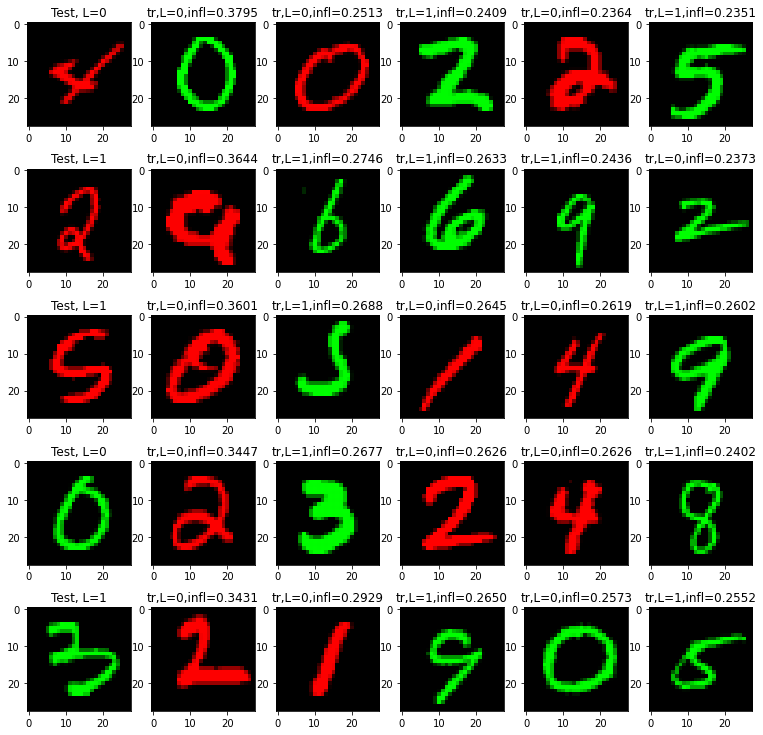

In [139]:
fig = plt.figure(figsize=(13, 13))
ax = []
idx_sorted = np.argsort(np.max(infl_est_irm, axis=1))[::-1]
for i in range(5):
    idx_tt = idx_sorted[i]
    img, label = test_set[idx_tt]
    ax.append(fig.add_subplot(5, 6, 1 + i*6))
    ax[-1].set_title(f'Test, L={label}') 
    plt.imshow(img)
    tr_ind = np.argsort(infl_est_irm[idx_tt])[::-1]
    for ind in range(5):
        img, label = trainall_set[tr_ind[ind]]
        infl = infl_est_irm[idx_tt, tr_ind[ind]]
        ax.append(fig.add_subplot(5, 6, 2 + ind + i*6))
        ax[-1].set_title(f'tr,L={label},infl={infl:.4f}') 
        plt.imshow(img)    
plt.show()  

# Accuracy: ERM vs IRM

In [169]:
trainset_correctness.mean()

0.827279775

In [170]:
trainset_correctness_irm.mean()

0.7152107536764706

In [171]:
testset_correctness.mean()

0.13703035

In [172]:
testset_correctness_irm.mean()

0.5601724264705882

In [173]:
testset_correctness_sample = testset_correctness.mean(axis = 0)
testset_maxinfl = np.max(infl_est, axis=1)

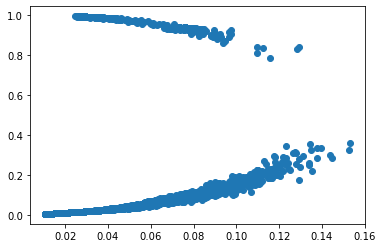

In [174]:
plt.scatter(testset_maxinfl, testset_correctness_sample)
plt.savefig('maxinfl_acc.png', dpi=300, bbox_inches='tight') 
plt.show()

In [145]:
testset_correctness_sample_irm = testset_correctness_irm.mean(axis = 0)
testset_maxinfl_irm = np.max(infl_est_irm, axis=1)

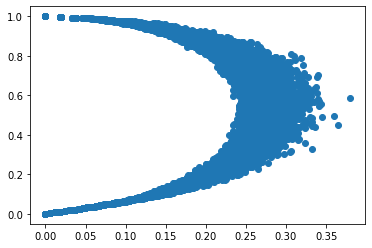

In [166]:
plt.scatter(testset_maxinfl_irm, testset_correctness_sample_irm)
plt.savefig('maxinfl_acc_irm.png', dpi=300, bbox_inches='tight') 
plt.show()

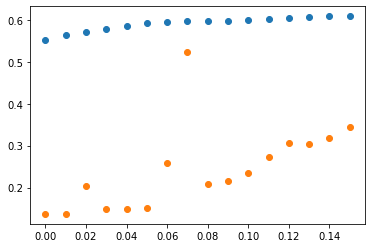

In [167]:
cuts = [i*0.01 for i in range(16)]

accs = []
for cut in cuts: 
    mask = (testset_maxinfl > cut)
    accs.append(_masked_avg(testset_correctness_sample, mask, axis=0, esp=1e-10))  
accs_irm = []
for cut in cuts: 
    mask = (testset_maxinfl_irm > cut)
    accs_irm.append(_masked_avg(testset_correctness_sample_irm, mask, axis=0, esp=1e-10)) 
plt.scatter(cuts, accs_irm)
plt.scatter(cuts, accs)
plt.savefig('maxinfl_acc_compare.png', dpi=300, bbox_inches='tight') 
plt.show()